# SMS Spam Detection System

## Authors: Temirlan Ismukhanov, Zhandos Sembay


# Importing Libraries

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Warnings
import warnings
warnings.filterwarnings('ignore')


# Text Preprocessing
import nltk

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer





# Import Dataset

In [14]:
messages = pd.read_csv("spam.csv", encoding = 'latin-1')

messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)

messages.columns = ["category", "text"]





In [15]:
messages.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Show Statistics

In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
category    5572 non-null object
text        5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


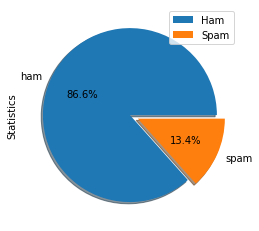

In [17]:
messages["category"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (4, 4), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Statistics")
plt.legend(["Ham", "Spam"])
plt.show()

In [18]:
topMessages = messages.groupby("text")["category"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 5)
display(topMessages)

,len,amax
text,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham


In [19]:
spam_messages = messages[messages["category"] == "spam"]["text"]
ham_messages = messages[messages["category"] == "ham"]["text"]

spam_words = []
ham_words = []

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

spam_messages.apply(extractSpamWords)
ham_messages.apply(extractHamWords)

0       None
1       None
3       None
4       None
6       None
7       None
10      None
13      None
14      None
16      None
17      None
18      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
35      None
36      None
37      None
38      None
        ... 
5538    None
5539    None
5541    None
5542    None
5543    None
5544    None
5545    None
5546    None
5548    None
5549    None
5550    None
5551    None
5552    None
5553    None
5554    None
5555    None
5556    None
5557    None
5558    None
5559    None
5560    None
5561    None
5562    None
5563    None
5564    None
5565    None
5568    None
5569    None
5570    None
5571    None
Name: text, Length: 4825, dtype: object

In [20]:
spam_words = np.array(spam_words)
print("Top 10 Spam words are :\n")
pd.Series(spam_words).value_counts().head(n = 10)

Top 10 Spam words are :



call      346
free      217
txt       156
u         144
ur        144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [21]:
ham_words = np.array(ham_words)
print("Top 10 Ham words are :\n")
pd.Series(ham_words).value_counts().head(n = 10)

Top 10 Ham words are :



u       974
gt      318
lt      316
get     301
go      246
ok      246
got     242
ur      237
know    234
like    231
dtype: int64

In [22]:
messages["messageLength"] = messages["text"].apply(len)
messages["messageLength"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: messageLength, dtype: float64

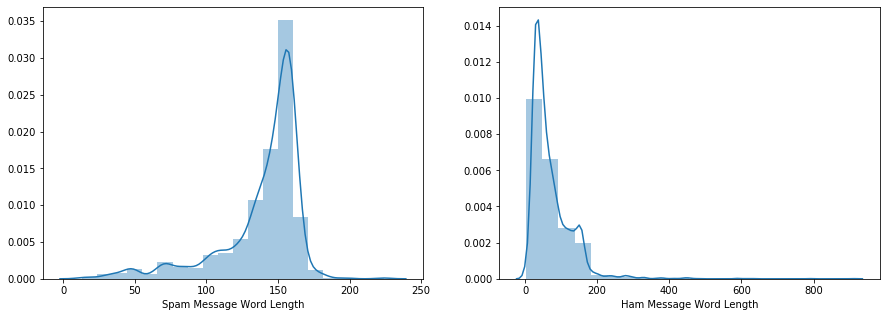

In [23]:
f, ax = plt.subplots(1, 2, figsize = (15, 5))

sns.distplot(messages[messages["category"] == "spam"]["messageLength"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Message Word Length")

sns.distplot(messages[messages["category"] == "ham"]["messageLength"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Message Word Length")

plt.show()

In [26]:
messages['length'] = messages['text'].apply(len) 
messages.head()

,category,text,messageLength,length
0,ham,"Go until jurong point, crazy.. Available only ...",111,111
1,ham,Ok lar... Joking wif u oni...,29,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,155
3,ham,U dun say so early hor... U c already then say...,49,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,61


In [27]:
# We can clearly see more negative cases than positive
messages.category = messages.category.map({"ham":0, "spam":1})
messages.category.value_counts()

0    4825
1     747
Name: category, dtype: int64

# Split into train and test sets

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(messages.text, messages.category, test_size=0.2)

# Create Document Train Matrix

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [30]:
trained_features = couvec.get_feature_names()
print("Number of features vectorized:", len(trained_features))
print("Examples of trained features:", trained_features[1:10])

Number of features vectorized: 7696
Examples of trained features: ['000', '008704050406', '0089', '0121', '01223585334', '02', '0207', '02072069400', '02073162414']


In [31]:
#train docs
dtm_train = couvec.fit_transform(X_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2])

Shape of dtm_train: (4457, 7696)
  (0, 2229)	1
  (0, 4305)	1
  (0, 3333)	1
  (1, 7481)	1
  (1, 1725)	1
  (1, 2773)	1
  (1, 4880)	1
  (1, 6389)	1
  (1, 1609)	1
  (1, 6737)	1
  (1, 2983)	1


In [32]:
# test docs
dtm_test = couvec.transform(X_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7696)


# Building and evaluating a model (MultinomialNB)

In [33]:
nb = MultinomialNB()

In [34]:
# train the model
nb.fit(dtm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
# make predictions
labels_pred = nb.predict(dtm_test)

In [36]:
# accuracy not an important metric when positive and negative classes are skewed
from sklearn import metrics
metrics.accuracy_score(y_test, labels_pred)

0.97847533632287

In [37]:
# create confusion matrix to see precision and recall
metrics.confusion_matrix(y_test, labels_pred)

array([[964,   7],
       [ 17, 127]])

In [38]:
# percentage of total spam detected i.e.recall
print("Recall:", metrics.recall_score(y_test, labels_pred))
# percentage of positive (spam) predictions that are correct i.e. precision
print("Precision:", metrics.precision_score(y_test, labels_pred))

Recall: 0.8819444444444444
Precision: 0.9477611940298507


In [39]:
print("Order of classes in predict_proba:", nb.classes_)
print("Example class probabilities:", nb.predict_proba(dtm_test)[0])

Order of classes in predict_proba: [0 1]
Example class probabilities: [9.99999999e-01 5.20490600e-10]


In [40]:
# since only ~15% of labels are positive (spam), a precision-recall curve is more useful than
# ROC curve
labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, 
                                                                 labels_prob)

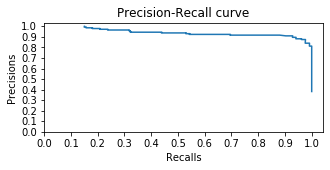

In [41]:
# plotting precision-recall curve
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 2))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisions")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall curve")
plt.show()

# Building and evaluating a model (SVM)


In [42]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


In [43]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [44]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[968   3]
 [ 31 113]]
